# Structural evolution of H1.0

In [2]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np

sys.path.append('../../src')
import data_utils
import analyse_utils

## Data preparation

In [ ]:
# Getting previous experiment json
metadata_path = f'../ortho_h1-0/ortho_h1-0.json'
with open(metadata_path, 'r') as file:
    metadata = json.load(file)
templates = pd.DataFrame(metadata['templates']).transpose()
data = pd.DataFrame(metadata['data']).transpose()

In [ ]:
# Getting previous analysis results containing outlier definitions
ortho = pd.read_pickle('../ortho_h1-0/results/analysis.pkl')

In [ ]:
# Filtering sequences by previous outlier definition
data = data[~ortho.outlier]
templates = templates.loc[data.index]

In [ ]:
# Generating average sequence
avg = data_utils.average_sequence(data['sequence'])
avg

'KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKSPVKKAKAAKPAAKKKKSSKKKLKKRTKGKPKGTAKPASKAPKKTAPKKAKAGKPKKVKAKATVPA'

In [ ]:
# Saving sequence
avg_name = 'H1-0_AVG'
file_path = f'data/{avg_name}.fasta'
with open(file_path, 'w') as file:
    file.write(">" + avg_name + "\n")
    file.write(avg + "\n")

In [ ]:
# Saving new experiment json
metadata['data'] = {avg_name: {'template': list(templates.index), 'sequence': avg, 'location': None, 'region': 'CTD', 'variant': 'Averaged'}}
metadata_path = f'idpevo_h1-0.json'
with open(metadata_path, 'w') as file:
    json.dump(metadata, file, indent=4)

## Analysis

In [3]:
# Loading metadata
metadata = analyse_utils.load_metadata('idpevo_h1-0.json', join=False)[0]
seq = metadata.iloc[0].sequence
metadata

,location,region,sequence,template,variant
H1-0_AVG,None,CTD,KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKSPV...,"[0_AUSLI, 1_CYPVA, 2_FUNHE, 3_KRYMA, 4_NOTFU, ...",Averaged


### Sequence characteristics

#### CIDER parameters

In [7]:
# Calculating parameters
cider = analyse_utils.cider_parameters(metadata['sequence'])
cider['Length'] = metadata.sequence.str.len()
cider['Charge'] = (cider.Length * cider.NCPR).astype(int)

cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.,Length,Charge
H1-0_AVG,0.18243,0.440367,0.385321,3.17156,0.917431,109,42


#### Amino acid content

In [17]:
# Calculating frequencies
freqs = analyse_utils.amino_acid_content(metadata.sequence)

freqs

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
H1-0_AVG,0.201835,0.0,0.009174,0.018349,0.009174,0.027523,0.0,0.0,0.385321,0.009174,0.0,0.0,0.119266,0.0,0.027523,0.073394,0.055046,0.06422,0.0,0.0


In [20]:
# Calculating counts
(freqs * len(seq)).astype(int)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
H1-0_AVG,22,0,1,2,1,3,0,0,42,1,0,0,13,0,3,8,6,7,0,0


### Evolution

In [11]:
# Loading data files
minevo = pd.read_pickle('results/0/evolution.pkl')
minevo_rep = pd.read_pickle('results/0_rep/evolution.pkl')
maxevo = pd.read_pickle('results/10/evolution.pkl')
consevo = pd.read_pickle('results/4.258203/evolution.pkl')


In [15]:
maxevo

,fasta,obs,simulate,mc,mc_cp
0,"[K, E, A, V, A, K, A, S, A, K, K, S, K, K, T, ...",4.156742,True,True,0.014427
1,"[K, E, A, V, A, K, A, S, A, K, K, S, K, K, T, ...",4.158379,False,True,0.014427
2,"[A, E, A, V, A, K, A, S, A, K, K, S, K, K, T, ...",4.140245,False,False,0.014427
3,"[K, E, A, V, A, K, A, S, A, K, K, S, K, K, T, ...",4.158813,False,True,0.014427
4,"[K, E, A, V, A, K, A, S, A, K, K, S, K, K, T, ...",4.149862,True,False,0.014427
...,...,...,...,...,...
2583,"[E, D, K, P, P, K, T, K, K, R, K, A, T, V, A, ...",4.211087,False,False,0.012917
2584,"[E, D, K, P, P, K, T, K, K, R, K, A, T, V, S, ...",4.219676,False,True,0.012917
2585,"[E, D, K, P, P, K, T, K, K, R, K, A, T, V, S, ...",4.204441,False,True,0.012917
2586,"[E, D, K, K, P, K, T, K, K, R, K, A, T, V, S, ...",4.191242,False,True,0.012917


(3.6, 4.4)

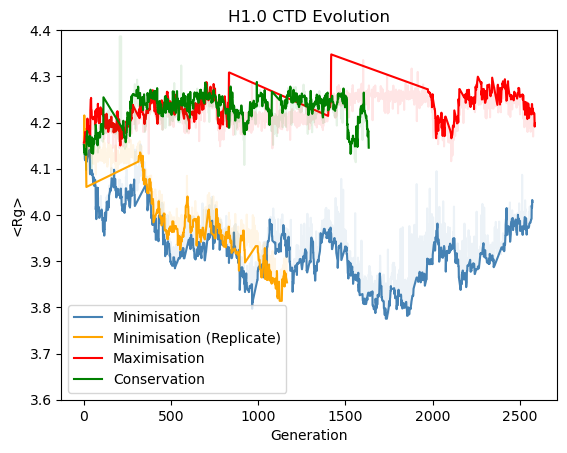

In [29]:
# Plotting results
plt.plot(minevo[minevo.mc].obs, label="Minimisation", c='steelblue')
plt.plot(minevo.obs, alpha=0.1, c='steelblue')
plt.plot(minevo_rep[minevo_rep.mc].obs, label="Minimisation (Replicate)", c='orange')
plt.plot(minevo_rep.obs, alpha=0.1, c='orange')
plt.plot(maxevo[maxevo.mc].obs, label="Maximisation", c='red')
plt.plot(maxevo.obs, alpha=0.1, c='red')
plt.plot(consevo[consevo.mc].obs, label="Conservation", c='green')
plt.plot(consevo.obs, alpha=0.1, c='green')
plt.xlabel("Generation")
plt.ylabel("<Rg>")
plt.title("H1.0 CTD Evolution")
plt.legend()
plt.ylim(3.6,4.4)


#### Minimization

(3.6, 4.4)

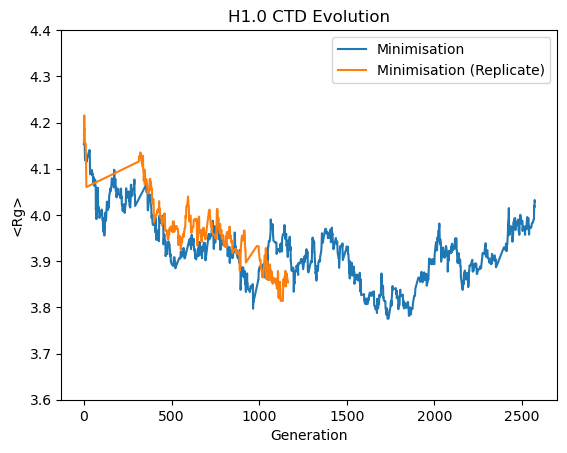

In [9]:
plt.plot(minevo[minevo.mc].obs, label="Minimisation")
plt.plot(minevo_rep[minevo_rep.mc].obs, label="Minimisation (Replicate)")
plt.xlabel("Generation")
plt.ylabel("<Rg>")
plt.title("H1.0 CTD Evolution")
plt.legend()
plt.ylim(3.6,4.4)

In [27]:
cider = analyse_utils.cider_parameters(minevo[minevo.mc].apply(lambda row: ''.join(row.fasta), axis=1))
cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.
0,0.182430,0.440367,0.385321,3.17156,0.917431
2,0.182430,0.440367,0.385321,3.17156,0.917431
3,0.182430,0.440367,0.385321,3.17156,0.917431
4,0.182430,0.440367,0.385321,3.17156,0.917431
6,0.191479,0.440367,0.385321,3.17156,0.917431
...,...,...,...,...,...
1849,0.402777,0.440367,0.385321,3.17156,0.917431
1851,0.402777,0.440367,0.385321,3.17156,0.917431
1852,0.402777,0.440367,0.385321,3.17156,0.917431
1853,0.402777,0.440367,0.385321,3.17156,0.917431


In [ ]:
neg = minevo[minevo.mc].apply(lambda row: [i+1 for i, aa in enumerate(row.fasta) if aa in ['D', 'E'] or i+1 == len(seq)], axis=1)

Text(0, 0.5, 'pos. of neg. res.')

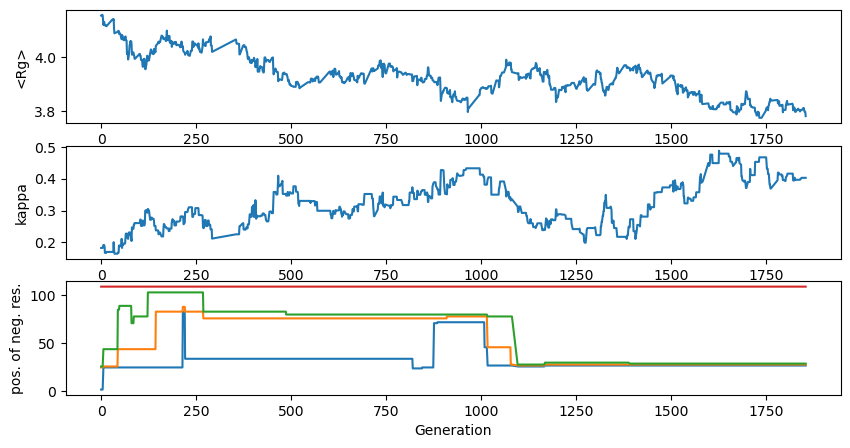

In [66]:
fig, axes = plt.subplots(3,1, figsize=(10,5))

axes[0].plot(minevo[minevo.mc].obs)
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("<Rg>")

axes[1].plot(cider.kappa)
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("kappa")

axes[2].plot(neg.explode()[0::4])
axes[2].plot(neg.explode()[1::4])
axes[2].plot(neg.explode()[2::4])
axes[2].plot(neg.explode()[3::4])
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("pos. of neg. res.")

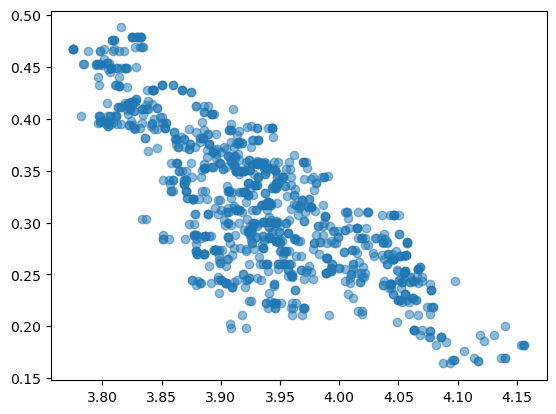

In [34]:
plt.scatter(minevo[minevo.mc].obs, cider.kappa, alpha=0.5)